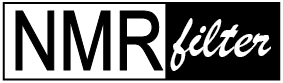



# Run NMRfilter

This is a tool developed to aid compound identification using 2D NMR data. It can be used with HSQC, HMBC, and HSQC-TOCSY; or HSQC and HMBC, or even with HSQC alone. NMRfilter takes into consideration: (i) proximity of simulated NMR chemical shifts to the experimental data; (ii) connectivity between long range scalar coupling (<sup>n</sup>_J_<sub>CH</sub> and <sup>n</sup>_J_<sub>HH</sub>); and (iii) peak matching on each specific spectra.
It also finds a good fit within pipelines that uses fractionation and NMR data acquisition for deep annotation of compounds of interest. 

It can be implemented as part of a pipeline to aid compound identification and to determine compounds of interest (consider also [DAFdiscovery](https://github.com/RicardoMBorges/DAFdiscovery)).

#### Input:
* Candidate list: names and [SMILES strings](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) 
* Peak list for each available 2D NMR data

#### Important: 
* An important part of NMRfilter relies at an NMR database of compounds and chemical shifts. Thus, if there are structures in the database similar to those to be observed, the simulation result will be more accurate. Please, submit NMR data into open-access database (preferred: [nmrsiftdb2](https://nmrshiftdb.nmr.uni-koeln.de/)).
* Solvents can be specified, but the accuracy will depend on the presence of similar compounds in the database with data acquired under the same solvent. 

#### References:

* [An integrated approach for mixture analysis using MS and NMR techniques at Faraday Discussion 2019](https://pubs.rsc.org/en/content/articlelanding/2019/fd/c8fd00227d).

* [Applying NMR compound identification using NMRfilter to match predicted to experimental data at Metabolomics Springer 2020](https://link.springer.com/article/10.1007/s11306-020-01748-1)
  
  

#### Tutorial:
Navegate to the NMRfilter directory to proceed with instalations according to the NMRfilter [GitHub repository](https://github.com/stefhk3/nmrfilter).
- The program is stored in a directory named nmrfilter
- Individual projects (for each study) are stored in different directories [projectFOLDER] within __a main directory__ (e.g. nmrfilterprojects) in the same directory level to nmrfilter. 
    - This path should be set at the __nmrproc.properties file__ together with input parameters.
- Once this is set, you can run the following code, chosing your project from the dropdown.

In [1]:
# Import Dependencies
import pandas as pd # Dataframes yield better visualizations of tables
import configparser
import configparser
import os
import subprocess
import sys
from clustering import *
from clusterlouvain import *
from similarity import *
from nmrutil import *
import ipywidgets as widgets

### Optional: Modify some parameters from the 'nmrproc.properties' file
* Users can opt to modify parameters using the following cell

In [18]:
file_path = 'nmrproc.properties'
changes = {
    'datadir': datapath,  # set the directory for the nmrfilterprojects
    'solvent': 'Methanol-D4 (CD3OD)',  # #option for solvent are: 
    #"Methanol-D4 (CD3OD)", "Chloroform-D1 (CDCl3)", "Dimethylsulphoxide-D6 (DMSO-D6, C2D6SO)", or "Unreported"
    'tolerancec': '0.3',  # Threshold for matching 13C chemical shift
    'toleranceh': '0.03',  #  Threshold for matching 1H chemical shift
    'rberresolution': '0.3',  # Threshold for the clustering search
    'usehsqctocsy': 'false',  # 'true' or 'false' to enable the use of HSQC-TOCSY data
    'usehmbc': 'true',  # 'true' or 'false' to enable the use of HMBC data
    'dotwobonds': 'false',  # 'true' or 'false' to specify the use of 2 bonds for the simulation of the HMBC data
    'usedeeplearning': 'true',  # 'true' or 'false' to enable the use of the ML method for the chemical shift prediction
    'debug':'true'  # 'true' or 'false' to enable the plot of the the unused peaks from the background
}

# Read the contents of the file
with open(file_path, 'r') as file:
    lines = file.readlines()

# Modify the lines according to the changes dictionary
for i, line in enumerate(lines):
    if '=' in line:
        key, value = line.strip().split('=')
        if key in changes:
            lines[i] = f"{key}={changes[key]}\n"

# Write the modified contents back to the file
with open(file_path, 'w') as file:
    file.writelines(lines)

In [19]:
# Select Project Master-Directory
cp = readprops()
datapath=cp.get('datadir')
projects = [f for f in os.listdir(datapath) if os.path.isdir(os.path.join(datapath, f))]
menu = widgets.Dropdown(
       options=projects,
       description='Chose your project:',
       style={'description_width': 'initial'})
menu

Dropdown(description='Chose your project:', options=('passifloraHSQCHMBC_DL', 'Sesquiterpenolactones_C_DL', 'n…

___
### Setting up the process parameters
* If needed, please, modify the file nmrproc.properties from the main nmrfilter directory

In [20]:
project = menu.value
print(f'Project = {project}; below are the parameters in use for this analysis.')
checkprojectdir(datapath, project, cp)
Parameters = pd.DataFrame.from_dict(cp, orient='index', columns=["inputs from properties"])
Parameters

Project = cotton; below are the parameters in use for this analysis.


,inputs from properties
datadir,/home/nmrbox/rborges/Desktop/GitHub/nmrfilterp...
msmsinput,testall.smi
predictionoutput,resultprediction.csv
result,result.txt
solvent,Methanol-D4 (CD3OD)
tolerancec,0.3
toleranceh,0.03
spectruminput,realspectrum.csv
clusteringoutput,cluster.txt
rberresolution,0.3


In [17]:
# if needed, here is a glossary of the terms used in NMRfilter
glossary = pd.read_csv("glossary.csv", sep=",")
glossary

,terms,definitions
0,datadir,"absolute directory (On Windows use ""\\"" as f..."
1,msmsinput,text file with the SMILES strings - candidate...
2,predictionoutput,files resulted from the predictions (resultpr...
3,result,file with att data calculated by NMRfilter (r...
4,solvent,option for solvent are Methanol-D4 (CD3OD) Ch...
5,tolerancec,tolerance threshold for the 13C axis\t(e.g. 0.2)
6,toleranceh,tolerance threshold for the 1H axis\t(e.g. 0.02)
7,spectruminput,peak picked list from the available 2D NMR da...
8,clusteringoutput,file with the clustered data from HMBC and HS...
9,rberresolution,tolerance threshold for the connectivity acro...


____
### Running predictions within NMRfilter

In [21]:
! java -cp "./*" uk.ac.dmu.simulate.Convert $project
sdf=cp.get("msmsinput")[0:-4]+".sdf"
if cp.get('usedeeplearning'):
    try:
        os.chdir('respredict')
        import predict as respredict
        respredict.predict(filename=datapath+os.sep+project+os.sep+sdf, format="sdf", nuc="13C", sanitize="True", addhs="False", output=datapath+os.sep+project+os.sep+"predc.json", model_meta_filename=None, model_checkpoint_filename=None)
        respredict.predict(filename=datapath+os.sep+project+os.sep+sdf, format="sdf", nuc="1H", sanitize="True", addhs="False", output=datapath+os.sep+project+os.sep+"predh.json", model_meta_filename=None, model_checkpoint_filename=None)
    finally:
        os.chdir('..')
! java -cp "./*" uk.ac.dmu.simulate.Simulate $project

true_testall.sdf_/home/nmrbox/rborges/Desktop/GitHub/nmrfilterprojects/org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bou

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement not included in bounds calculation
org.openscience.cdk.renderer.elements.Bounds WARN: class org.openscience.cdk.renderer.elements.AtomSymbolElement

____
### Running steps within NMRfilter

In [22]:
print("Clustering the peaks in the measured spectrum...")
cluster2dspectrum(cp, project)
print("Detecting communities in the measures spectrum...")
cluster2dspectrumlouvain(cp, project)
print("Calculating best hits in your compounds...")
print("Processed data: Results")
display(similarity(cp, project, False))

Clustering the peaks in the measured spectrum...
Detecting communities in the measures spectrum...
Calculating best hits in your compounds...
Processed data: Results
no shifts were predicted for ClC(Cl)=C(Cl)Cl and we cannot say anything about it!


,SMILES,Name,Distance,Standard deviation,Matching peaks HMBC,Mathcing rate HMBC,Matching peaks HSQC,Mathcing rate HSQC
1,C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(-c4ccc(O)...,LTS0032845,0.00,1.00,1/35,2.86%,14/17,82.35%
2,CCCCCC=CCCC(O)CCCCCCCC(=O)O,LTS0022980,0.00,0.96,10/31,32.26%,15/17,88.24%
3,CC1=CCC(C(C)C)C=C1,LTS0157173,0.00,0.94,7/21,33.33%,4/8,50.00%
4,CCCC1CCCC(=O)O1,LTS0182186,0.00,0.94,4/12,33.33%,5/7,71.43%
5,CC(=O)/C=C/C1=C(C)CCCC1(C)C,LTS0155301,0.00,0.90,8/19,42.11%,4/8,50.00%
...,...,...,...,...,...,...,...,...
314,CC[C@H]1CCC[C@H](O[C@H]2CC[C@H](N(C)C)[C@@H](C...,LTS0140618,0.94,0.77,0/95,0.00%,19/37,51.35%
315,CC(C)CCC[C@@H](C)[C@H]1CC[C@@]2(C)[C@@H]3CC[C@...,LTS0006427,0.65,0.46,5/81,6.17%,12/24,50.00%
316,CC(C)=CCC[C@@H](C)[C@H]1CC[C@@]2(C)[C@@H]3CC[C...,LTS0062833,0.56,0.36,0/78,0.00%,11/22,50.00%
317,CC(C)=CCC[C@@H](C)[C@H]1CC[C@@]2(C)[C@@H]3CC[C...,LTS0269561,0.56,0.36,0/78,0.00%,11/22,50.00%


In [7]:
%pwd

'/home/nmrbox/rborges/Desktop/GitHub/nmrfilter-master'

____
### Call images for visual validation (peak profiling and matching rates)

In [ ]:
data_project = datapath+os.sep+project+os.sep+'plots'+os.sep
from IPython.display import Image
files = [f[0:len(f)-4] for f in os.listdir(data_project) if not os.path.isdir(os.path.join(data_project, f))]
menu = widgets.Dropdown(
       options=files,
       description='Chose your compound:',
       style={'description_width': 'initial'})
menu


In [ ]:
target = menu.value
Image(filename=data_project+target
      +'.png')

In [36]:
data = (Parameters.loc['datadir']['inputs from properties'])
path = os.path.join(data, project, "result")
path_file = os.path.join(path, 'result.txt.csv')
# navigate to the directory
df = pd.read_csv(path_file, sep="\t")
df.rename(columns={'name':'lotus_id'}, inplace=True)
df.head(1)

,ID,smiles,lotus_id,distance,standard deviation,matching rate (HMBC),Unnamed: 6,matching rate (HSQC),Unnamed: 8
0,1,CC(C)=C1C/C=C(\C)CC/C=C(\C)CC1=O,LTS0207391,0.0,1.0,7/24,29.17%,8/10,80.00%


##### Indexing compound name from Lotus to this database

In [45]:
import os

data = (Parameters.loc['datadir']['inputs from properties'])
path = os.path.join(data, project, "result")
path_file = os.path.join(path, 'result.txt.csv')

df = pd.read_csv(path_file, sep="\t")
df.rename(columns={'name':'lotus_id'}, inplace=True)

# 1. get the structures and data from the master worksheet
df_lotus = pd.read_csv('LOTUS_2021_03_simple_extended.csv', sep = ',')
df_lotus2 = df_lotus.loc[:,["lotus_id","smiles"]]

df_Name_index = pd.merge(df, df_lotus, on='lotus_id')
df_Name_index2 = df_Name_index.loc[:,["lotus_id","name"]]

filename = "Lotus_name_index_annotation.csv"
csv_path = os.path.join(path, filename)
df_Name_index2.to_csv(csv_path, sep=";", index=False)
filename2 = "Lotus_name_index_annotation_Results.csv"
csv_path2 = os.path.join(path, filename2)
df_Name_index.to_csv(csv_path2, sep=";", index=False)

In [44]:
df_Name_index

,ID,smiles_x,lotus_id,distance,standard deviation,matching rate (HMBC),Unnamed: 6,matching rate (HSQC),Unnamed: 8,Unnamed: 0,smiles_y,name,MolFormula,Inchi,InchiKey,MolWeight,MolWeight-1H,MolWeight+1H,MolWeight+Na,MolWeight+K
0,1,CC(C)=C1C/C=C(\C)CC/C=C(\C)CC1=O,LTS0207391,0.00,1.00,7/24,29.17%,8/10,80.00%,207390,CC1=CCC(=C(C)C)C(=O)CC(C)=CCC1,germacrone,C15H22O,InChI=1S/C15H22O/c1-11(2)14-9-8-12(3)6-5-7-13(...,CAULGCQHVOVVRN-UHFFFAOYSA-N,218.167065,217.159241,219.174889,241.156835,257.130765
1,2,CCCCCC=CCCC(O)CCCCCCCC(=O)O,LTS0022980,0.00,0.98,10/31,32.26%,15/17,88.24%,22979,CCCCCC=CCCC(O)CCCCCCCC(=O)O,9-hydroxyoctadec-12-enoic acid,C18H34O3,InChI=1S/C18H34O3/c1-2-3-4-5-6-8-11-14-17(19)1...,BNZYDQIAPCVNAT-UHFFFAOYSA-N,298.250795,297.242971,299.258619,321.240565,337.214495
2,3,CC(C)=CCC/C(C)=C/CO,LTS0258838,0.00,0.97,7/14,50.00%,5/7,71.43%,258837,CC(C)=CCCC(C)=CCO,geraniol,C10H18O,"InChI=1S/C10H18O/c1-9(2)5-4-6-10(3)7-8-11/h5,7...",GLZPCOQZEFWAFX-UHFFFAOYSA-N,154.135765,153.127941,155.143589,177.125535,193.099465
3,4,CC(C)=CCC/C(C)=C\CO,LTS0244289,0.00,0.97,7/14,50.00%,5/7,71.43%,244288,CC(C)=CCCC(C)=CCO,nerol,C10H18O,"InChI=1S/C10H18O/c1-9(2)5-4-6-10(3)7-8-11/h5,7...",GLZPCOQZEFWAFX-UHFFFAOYSA-N,154.135765,153.127941,155.143589,177.125535,193.099465
4,5,CC(C)=CCCC(C)CCO,LTS0090925,0.00,0.95,9/16,56.25%,7/8,87.50%,90924,CC(C)=CCCC(C)CCO,"citronellol, (+-)-",C10H20O,"InChI=1S/C10H20O/c1-9(2)5-4-6-10(3)7-8-11/h5,1...",QMVPMAAFGQKVCJ-UHFFFAOYSA-N,156.151415,155.143591,157.159239,179.141185,195.115115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,314,CC(C)=CCC[C@@H](C)[C@H]1CC[C@@]2(C)[C@@H]3CC[C...,LTS0062833,0.56,0.53,0/78,0.00%,11/22,50.00%,62832,CC(C)=CCCC(C)C1CCC2(C)C3CCC4C(C)(C)C(O)CCC45CC...,"(3r,6s,8r,11s,12s,15r,16r)-7,7,12,16-tetrameth...",C30H50O,InChI=1S/C30H50O/c1-20(2)9-8-10-21(3)22-13-15-...,ONQRKEUAIJMULO-UHFFFAOYSA-N,426.386166,425.378342,427.393990,449.375936,465.349866
314,315,CC(C)=CCC[C@@H](C)[C@H]1CC[C@@]2(C)[C@@H]3CC[C...,LTS0269561,0.56,0.53,0/78,0.00%,11/22,50.00%,269560,CC(C)=CCCC(C)C1CCC2(C)C3CCC4C(C)(C)C(O)CCC45CC...,cycloartenol,C30H50O,InChI=1S/C30H50O/c1-20(2)9-8-10-21(3)22-13-15-...,ONQRKEUAIJMULO-UHFFFAOYSA-N,426.386166,425.378342,427.393990,449.375936,465.349866
315,316,CC(C)=CCC[C@@H](C)[C@H]1CC[C@@]2(C)[C@@H]3CC[C...,LTS0060148,0.62,0.54,1/80,1.25%,12/23,52.17%,60147,CC(C)=CCCC(C)C1CCC2(C)C3CCC4C(C)C(O)CCC45CC35C...,"(1s,3r,6s,7s,8s,11s,12s,15r,16r)-7,12,16-trime...",C29H48O,InChI=1S/C29H48O/c1-19(2)8-7-9-20(3)22-12-14-2...,XZEUYTKSAYNYPK-UHFFFAOYSA-N,412.370516,411.362692,413.378340,435.360286,451.334216
316,317,CC[C@H]1CCC[C@H](O[C@H]2CC[C@H](N(C)C)[C@@H](C...,LTS0061605,1.00,0.87,0/98,0.00%,19/38,50.00%,61604,CCC1CCCC(OC2CCC(N(C)C)C(C)O2)C(C)C(=O)C2=CC3C(...,spinosyn d,C42H67NO10,InChI=1S/C42H67NO10/c1-11-26-13-12-14-35(53-37...,RDECBWLKMPEKPM-UHFFFAOYSA-N,745.476497,744.468673,746.484321,768.466267,784.440197


#### THANK YOU for using NMRfilter. Please, keep in touch as we continue to improve it.
Stefan Kuhn: stefan.kuhn@dmu.ac.uk

Ricardo M. Borges: ricardo_mborges@ufrj.br